# Hymba Ablation Study - Tiny Shakespeare

## 목표
다양한 아키텍처 구성의 성능을 비교하여 각 컴포넌트의 기여도를 분석합니다.

### 테스트 구성
1. **Mamba-only**: SSM 기반 시퀀스 모델링
2. **Transformer-only**: 표준 어텐션 기반
3. **Hybrid (Hymba)**: Attention + Mamba 혼합
   - Global Attention: 첫/중간/마지막 레이어
   - Local Attention (SWA): 나머지 레이어
   - Meta Tokens: 128개
   - KV-Cache 공유

### 평가 메트릭
- 학습 Loss & Perplexity
- 검증 Loss & Perplexity
- 학습 속도 (tokens/sec)
- 추론 속도 (tokens/sec)
- KV-Cache 메모리 절감
- 생성 품질

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

# Warning 제거
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm

# 모듈 리로드 (코드 변경사항 반영)
import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import Hymba, HymbaConfig, ArchType, AttentionType

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Sequence as NormSeq, NFKC, Lowercase

# 결과 저장 폴더
RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Results will be saved to: {RESULTS_DIR}")

# 시각화 설정
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid")

Device: cuda
Results will be saved to: ./results


## 1. 데이터 준비

In [2]:
# Tiny Shakespeare 로드
print("데이터 로딩 중...")
ds = load_dataset("karpathy/tiny_shakespeare")
text = "\n\n".join(ds["train"]["text"])

print(f"전체 텍스트 길이: {len(text):,} 문자")
print(f"\n샘플:\n{text[:500]}...")

데이터 로딩 중...
전체 텍스트 길이: 1,003,854 문자

샘플:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor...


In [3]:
# 토크나이저 학습
print("\n토크나이저 학습 중...")
vocab_size = 4000

tk = Tokenizer(Unigram())
tk.normalizer = NormSeq([NFKC(), Lowercase()])
tk.pre_tokenizer = Whitespace()
trainer = UnigramTrainer(vocab_size=vocab_size, special_tokens=["<|unk|>"], unk_token="<|unk|>")
tk.train_from_iterator([text], trainer=trainer)

class TokenizerWrap:
    def __init__(self, tk):
        self.tk = tk
    def encode(self, s):
        return self.tk.encode(s).ids
    def decode(self, ids):
        return self.tk.decode(ids)
    @property
    def vocab_size(self):
        return self.tk.get_vocab_size()

tokenizer = TokenizerWrap(tk)
print(f"어휘 크기: {tokenizer.vocab_size}")


토크나이저 학습 중...


어휘 크기: 4000


In [4]:
# 데이터로더 생성
def make_dataset(tok, text, seq_len=256):
    ids = np.array(tok.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n = (len(y) // seq_len) * seq_len
    X = torch.tensor(x[:n].reshape(-1, seq_len))
    Y = torch.tensor(y[:n].reshape(-1, seq_len))
    return TensorDataset(X, Y)

seq_len = 256
batch_size = 16

ds_full = make_dataset(tokenizer, text, seq_len)
tr_len = int(0.9 * len(ds_full))
va_len = len(ds_full) - tr_len
train_ds, val_ds = random_split(ds_full, [tr_len, va_len])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"\n학습 배치: {len(train_dl)}")
print(f"검증 배치: {len(val_dl)}")


학습 배치: 64
검증 배치: 8


## 2. 모델 구성 정의

In [5]:
# 기본 하이퍼파라미터 (15 레이어로 증가)
base_config = {
    "vocab_size": vocab_size,
    "d_model": 512,
    "n_layers": 15,
    "n_heads": 8,
    "n_kv_heads": 4,
    "swa_window": 128,
    "dropout": 0.1,
    "seq_len": seq_len,
}

# 테스트 구성들
# 참고: mamba_heads_per_layer는 레이어당 Mamba head 수
#       n_heads는 레이어당 Attention head 수 (Hybrid에서)
#       따라서 Mamba:Attn 비율 = mamba_heads_per_layer : 1 (레이어 기준)
configs = {
    "Mamba-only": HymbaConfig(
        **base_config,
        arch_type=ArchType.MAMBA_ONLY,
        mamba_heads_per_layer=1,
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    "Transformer-only (Global)": HymbaConfig(
        **base_config,
        arch_type=ArchType.TRANSFORMER_ONLY,
        global_attn_indices=list(range(15)),  # 모든 레이어 Global
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    "Hybrid (1:1)": HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=1,  # 1:1 비율 (레이어당)
        global_attn_indices=[0, 7, 14],
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
    "Hybrid (5:1 Mamba)": HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=5,  # 5:1 비율 (레이어당 Mamba 5개)
        global_attn_indices=[0, 7, 14],
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
}

print("=== 테스트 구성 ===")
for name, cfg in configs.items():
    layer_configs = cfg.get_layer_configs()
    total_attn = sum(c[0] for c in layer_configs)
    total_mamba = sum(c[1] for c in layer_configs)
    print(f"\n{name}:")
    print(f"  arch_type: {cfg.arch_type.value}")
    print(f"  Total Attn heads: {total_attn}, Total Mamba heads: {total_mamba}")
    if cfg.arch_type == ArchType.HYBRID:
        print(f"  Per-layer config: Attn={layer_configs[0][0]}, Mamba={layer_configs[0][1]}")
        print(f"  Mamba:Attn ratio (per layer): {layer_configs[0][1]}:1")
    if cfg.use_meta_tokens:
        print(f"  Meta tokens: {cfg.num_meta_tokens}")
    if cfg.use_kv_sharing:
        print(f"  KV Sharing: Enabled")

=== 테스트 구성 ===

Mamba-only:
  arch_type: mamba
  Total Attn heads: 0, Total Mamba heads: 15

Transformer-only (Global):
  arch_type: transformer
  Total Attn heads: 120, Total Mamba heads: 0

Hybrid (1:1):
  arch_type: hybrid
  Total Attn heads: 120, Total Mamba heads: 15
  Per-layer config: Attn=8, Mamba=1
  Mamba:Attn ratio (per layer): 1:1
  Meta tokens: 64
  KV Sharing: Enabled

Hybrid (5:1 Mamba):
  arch_type: hybrid
  Total Attn heads: 120, Total Mamba heads: 75
  Per-layer config: Attn=8, Mamba=5
  Mamba:Attn ratio (per layer): 5:1
  Meta tokens: 64
  KV Sharing: Enabled


## 3. 학습 함수

In [6]:
def train_model_enhanced(model, train_dl, val_dl, epochs=30, lr=3e-4, warmup_steps=200, 
                         eval_interval=32, device='cuda', stage_name="Pretraining"):
    """
    개선된 모델 학습 함수
    - Cosine Annealing with Linear Warmup
    - BF16 Mixed Precision Training
    - Gradient Clipping
    - Detailed logging
    
    Args:
        model: Hymba 모델
        train_dl: 학습 데이터로더
        val_dl: 검증 데이터로더
        epochs: 학습 에포크 수
        lr: 최대 learning rate
        warmup_steps: Warmup 스텝 수
        eval_interval: Validation 수행 간격
        device: 학습 디바이스
        stage_name: 학습 단계 이름 (Pretraining/ORPO)
    
    Returns:
        dict: 학습 결과 및 history
    """
    model = model.to(device).train()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.95), 
        weight_decay=0.1,
        eps=1e-8
    )
    
    total_steps = epochs * len(train_dl)
    
    # Cosine Annealing with Linear Warmup
    def lr_schedule(step):
        if step < warmup_steps:
            # Linear warmup
            return step / warmup_steps
        else:
            # Cosine annealing
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    
    # BF16 Mixed Precision
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    if use_amp:
        scaler = torch.amp.GradScaler('cuda')
        print(f"  Using BF16 AMP for {stage_name}")
    else:
        scaler = None
        print(f"  Using FP32 for {stage_name}")
    
    # History tracking
    history = {
        "train_loss": [], 
        "val_loss": [], 
        "train_ppl": [],
        "val_ppl": [],
        "lr": [],
        "step": [],
        "epoch": []
    }
    
    step = 0
    t0 = time.time()
    best_val_loss = float('inf')
    best_epoch = 0
    
    print(f"\n{'='*80}")
    print(f"Starting {stage_name}")
    print(f"{'='*80}")
    print(f"  Total Steps: {total_steps}")
    print(f"  Warmup Steps: {warmup_steps}")
    print(f"  Max LR: {lr}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {train_dl.batch_size}")
    print(f"{'='*80}\n")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_tokens = 0
        
        pbar = tqdm(train_dl, desc=f"[{stage_name}] Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            # Forward & Backward
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    loss = out["loss"]
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                loss = out["loss"]
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            
            epoch_loss += loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            # Validation
            if step % eval_interval == 0 or step == total_steps:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        val_loss += vout["loss"].item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                current_lr = scheduler.get_last_lr()[0]
                
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["train_ppl"].append(np.exp(train_loss))
                history["val_ppl"].append(np.exp(val_loss))
                history["lr"].append(current_lr)
                history["step"].append(step)
                history["epoch"].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                
                pbar.set_postfix({
                    "loss": f"{train_loss:.3f}",
                    "val": f"{val_loss:.3f}",
                    "ppl": f"{np.exp(val_loss):.2f}",
                    "lr": f"{current_lr:.2e}",
                    "grad": f"{grad_norm:.2f}"
                })
                
                model.train()
    
    elapsed = time.time() - t0
    total_tokens = epochs * len(train_dl) * train_dl.batch_size * seq_len
    tps = int(total_tokens / elapsed)
    
    print(f"\n{'='*80}")
    print(f"{stage_name} Completed")
    print(f"{'='*80}")
    print(f"  Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Training Time: {elapsed/60:.1f} min")
    print(f"  Throughput: {tps:,} tokens/sec")
    print(f"{'='*80}\n")
    
    return {
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "train_ppl": history["train_ppl"][-1],
        "val_ppl": history["val_ppl"][-1],
        "best_val_ppl": np.exp(best_val_loss),
        "train_tps": tps,
        "time_min": elapsed / 60,
        "history": history,
    }


def train_orpo(model, train_dl, val_dl, epochs=10, lr=1e-4, warmup_steps=100, 
               beta=0.1, eval_interval=32, device='cuda'):
    """
    ORPO (Odds Ratio Preference Optimization) 학습 - 단순화 버전
    
    ⚠️ 주의: 이 구현은 preference pair (chosen/rejected) 데이터 없이 진행되는 
    단순화된 버전입니다. 실제 ORPO는 선호/비선호 응답 쌍이 필요합니다.
    
    현재 구현:
    - SFT Loss + Log-likelihood 기반 regularization
    - 실제 ORPO의 odds ratio 계산 없음
    
    실제 ORPO 적용 시 필요:
    - chosen/rejected 응답 쌍 데이터셋
    - 두 응답에 대한 log-probability 계산
    - Odds ratio: log(P(chosen)/(1-P(chosen))) - log(P(rejected)/(1-P(rejected)))
    
    Args:
        model: Hymba 모델
        train_dl: 학습 데이터로더 (현재는 단일 텍스트만 포함)
        val_dl: 검증 데이터로더
        epochs: 학습 에포크 수
        lr: Learning rate (pretraining보다 낮게)
        warmup_steps: Warmup 스텝 수
        beta: Regularization 강도
        eval_interval: Validation 수행 간격
        device: 학습 디바이스
    
    Returns:
        dict: 학습 결과 및 history
    """
    model = model.to(device).train()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.95), 
        weight_decay=0.01  # 낮은 weight decay
    )
    
    total_steps = epochs * len(train_dl)
    
    def lr_schedule(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    history = {
        "train_loss": [],
        "orpo_loss": [],
        "sft_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
        "lr": [],
        "step": [],
        "epoch": []
    }
    
    step = 0
    t0 = time.time()
    best_val_loss = float('inf')
    
    print(f"\n{'='*80}")
    print(f"Starting ORPO Training (Simplified - No Preference Data)")
    print(f"{'='*80}")
    print(f"  ⚠️ This is a simplified version without preference pairs")
    print(f"  Beta (regularization strength): {beta}")
    print(f"  LR: {lr} (lower than pretraining)")
    print(f"  Epochs: {epochs}")
    print(f"{'='*80}\n")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_orpo_loss = 0.0
        epoch_sft_loss = 0.0
        epoch_tokens = 0
        
        pbar = tqdm(train_dl, desc=f"[ORPO] Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    logits = out["logits"]
                    
                    # SFT Loss (standard cross-entropy)
                    sft_loss = F.cross_entropy(
                        logits.reshape(-1, logits.size(-1)),
                        yb.reshape(-1),
                        ignore_index=-100
                    )
                    
                    # Simplified regularization (not true ORPO)
                    # 실제 ORPO는 chosen/rejected pair 비교 필요
                    log_probs = F.log_softmax(logits, dim=-1)
                    target_log_probs = torch.gather(
                        log_probs, 2, yb.unsqueeze(-1)
                    ).squeeze(-1)
                    
                    # 이 부분은 실제 ORPO가 아님 - 단순 regularization
                    orpo_penalty = -torch.mean(target_log_probs)
                    
                    # Total loss
                    loss = sft_loss + beta * orpo_penalty
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                logits = out["logits"]
                
                sft_loss = F.cross_entropy(
                    logits.reshape(-1, logits.size(-1)),
                    yb.reshape(-1),
                    ignore_index=-100
                )
                
                log_probs = F.log_softmax(logits, dim=-1)
                target_log_probs = torch.gather(
                    log_probs, 2, yb.unsqueeze(-1)
                ).squeeze(-1)
                orpo_penalty = -torch.mean(target_log_probs)
                
                loss = sft_loss + beta * orpo_penalty
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            
            epoch_loss += loss.item() * xb.numel()
            epoch_orpo_loss += orpo_penalty.item() * xb.numel()
            epoch_sft_loss += sft_loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            # Validation
            if step % eval_interval == 0 or step == total_steps:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        val_loss += vout["loss"].item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                orpo_loss = epoch_orpo_loss / epoch_tokens
                sft_loss_avg = epoch_sft_loss / epoch_tokens
                current_lr = scheduler.get_last_lr()[0]
                
                history["train_loss"].append(train_loss)
                history["orpo_loss"].append(orpo_loss)
                history["sft_loss"].append(sft_loss_avg)
                history["val_loss"].append(val_loss)
                history["train_ppl"].append(np.exp(sft_loss_avg))
                history["val_ppl"].append(np.exp(val_loss))
                history["lr"].append(current_lr)
                history["step"].append(step)
                history["epoch"].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                
                pbar.set_postfix({
                    "sft": f"{sft_loss_avg:.3f}",
                    "reg": f"{orpo_loss:.3f}",
                    "val": f"{val_loss:.3f}",
                    "ppl": f"{np.exp(val_loss):.2f}"
                })
                
                model.train()
    
    elapsed = time.time() - t0
    total_tokens = epochs * len(train_dl) * train_dl.batch_size * seq_len
    tps = int(total_tokens / elapsed)
    
    return {
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "best_val_loss": best_val_loss,
        "sft_loss": history["sft_loss"][-1],
        "orpo_loss": history["orpo_loss"][-1],
        "train_ppl": history["train_ppl"][-1],
        "val_ppl": history["val_ppl"][-1],
        "best_val_ppl": np.exp(best_val_loss),
        "train_tps": tps,
        "time_min": elapsed / 60,
        "history": history,
    }

## 4. 추론 속도 벤치마크

In [7]:
def benchmark_inference(model, tokenizer, prompt="ROMEO:", max_tokens=100, n_runs=3, device='cuda'):
    """
    추론 속도 측정
    """
    model = model.to(device).eval()
    prompt_tokens = tokenizer.encode(prompt)
    prompt_tensor = torch.tensor([prompt_tokens]).to(device)
    
    times = []
    for _ in range(n_runs):
        if device == 'cuda':
            torch.cuda.synchronize()
        
        t0 = time.time()
        with torch.no_grad():
            _ = model.generate(prompt_tensor, max_new_tokens=max_tokens, temperature=1.0)
        
        if device == 'cuda':
            torch.cuda.synchronize()
        
        elapsed = time.time() - t0
        times.append(elapsed)
    
    avg_time = np.mean(times)
    tps = max_tokens / avg_time
    
    return {"time_sec": avg_time, "tokens_per_sec": tps}

## 5. 모델 학습 및 평가

In [8]:
# 모든 구성 학습 - 2단계 학습 (Pretraining → ORPO)
results = {}

for name, cfg in configs.items():
    print(f"\n{'='*100}")
    print(f"Model: {name}")
    print(f"{'='*100}")
    
    # 모델 생성
    model = Hymba(cfg)
    params = model.count_parameters()
    print(f"Parameters: {params['total']:,}")
    
    # 아키텍처 정보
    if cfg.arch_type == ArchType.HYBRID:
        attn_info = model.get_attention_pattern_info()
        print(f"Attention Layers: {attn_info['num_global'] + attn_info['num_local']}/{cfg.n_layers}")
        print(f"Global Layers: {attn_info['global_layers']}")
        print(f"Local Layers: {attn_info['local_layers']}")
    
    # KV 공유 정보
    if cfg.arch_type != ArchType.MAMBA_ONLY:
        kv_info = model.get_kv_sharing_info()
        print(f"KV Cache Reduction: {kv_info['reduction']:.2f}x")
        print(f"Independent Caches: {kv_info['independent_caches']}/{kv_info['total_layers']}")
    
    # ========== Stage 1: Pretraining (30 epochs) ==========
    print(f"\n{'='*100}")
    print(f"STAGE 1: PRETRAINING")
    print(f"{'='*100}")
    
    pretrain_results = train_model_enhanced(
        model, train_dl, val_dl, 
        epochs=30,
        lr=3e-4,
        warmup_steps=200,
        eval_interval=32,
        device=device,
        stage_name="Pretraining"
    )
    
    # 모델 체크포인트 저장 (pretraining 완료)
    pretrain_state = {
        'model_state': model.state_dict(),
        'val_loss': pretrain_results['val_loss'],
        'val_ppl': pretrain_results['val_ppl'],
    }
    
    # ========== Stage 2: ORPO (10 epochs) ==========
    print(f"\n{'='*100}")
    print(f"STAGE 2: ORPO (Reinforcement Learning)")
    print(f"{'='*100}")
    
    orpo_results = train_orpo(
        model, train_dl, val_dl,
        epochs=10,
        lr=1e-4,  # Lower LR than pretraining
        warmup_steps=100,
        beta=0.1,  # ORPO penalty strength
        eval_interval=32,
        device=device
    )
    
    # 추론 벤치마크 (ORPO 완료 후)
    print(f"\nBenchmarking inference (after ORPO)...")
    infer_results = benchmark_inference(model, tokenizer, device=device)
    
    # 생성 샘플 (3개)
    print(f"\nGenerating samples (after ORPO)...")
    samples = []
    prompts_list = ["ROMEO:", "First Citizen:", "KING:"]
    for prompt in prompts_list:
        prompt_tokens = tokenizer.encode(prompt)
        prompt_tensor = torch.tensor([prompt_tokens]).to(device)
        with torch.no_grad():
            generated = model.generate(prompt_tensor, max_new_tokens=80, temperature=0.8, top_k=40)
        sample_text = tokenizer.decode(generated[0].cpu().tolist())
        samples.append(sample_text)
    
    # 결과 저장 (두 단계 모두 포함)
    results[name] = {
        # Pretraining results
        "pretrain_train_loss": pretrain_results['train_loss'],
        "pretrain_val_loss": pretrain_results['val_loss'],
        "pretrain_best_val_loss": pretrain_results['best_val_loss'],
        "pretrain_val_ppl": pretrain_results['val_ppl'],
        "pretrain_best_val_ppl": pretrain_results['best_val_ppl'],
        "pretrain_history": pretrain_results['history'],
        
        # ORPO results
        "orpo_train_loss": orpo_results['train_loss'],
        "orpo_val_loss": orpo_results['val_loss'],
        "orpo_best_val_loss": orpo_results['best_val_loss'],
        "orpo_val_ppl": orpo_results['val_ppl'],
        "orpo_best_val_ppl": orpo_results['best_val_ppl'],
        "orpo_sft_loss": orpo_results['sft_loss'],
        "orpo_penalty": orpo_results['orpo_loss'],
        "orpo_history": orpo_results['history'],
        
        # Final metrics
        "final_val_loss": orpo_results['val_loss'],
        "final_val_ppl": orpo_results['val_ppl'],
        "best_val_loss": min(pretrain_results['best_val_loss'], orpo_results['best_val_loss']),
        "best_val_ppl": min(pretrain_results['best_val_ppl'], orpo_results['best_val_ppl']),
        
        # Inference and other metrics
        **infer_results,
        "params": params['total'],
        "samples": samples,
        "kv_reduction": kv_info['reduction'] if cfg.arch_type != ArchType.MAMBA_ONLY else 1.0,
        "total_time_min": pretrain_results['time_min'] + orpo_results['time_min'],
    }
    
    print(f"\n{'='*100}")
    print(f"FINAL RESULTS (after both stages):")
    print(f"{'='*100}")
    print(f"\nPretraining Stage:")
    print(f"  Best Val Loss: {pretrain_results['best_val_loss']:.4f} | PPL: {pretrain_results['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {pretrain_results['val_loss']:.4f} | PPL: {pretrain_results['val_ppl']:.2f}")
    print(f"  Training Time: {pretrain_results['time_min']:.1f} min")
    
    print(f"\nORPO Stage:")
    print(f"  Best Val Loss: {orpo_results['best_val_loss']:.4f} | PPL: {orpo_results['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {orpo_results['val_loss']:.4f} | PPL: {orpo_results['val_ppl']:.2f}")
    print(f"  SFT Loss: {orpo_results['sft_loss']:.4f}")
    print(f"  ORPO Penalty: {orpo_results['orpo_loss']:.4f}")
    print(f"  Training Time: {orpo_results['time_min']:.1f} min")
    
    print(f"\nOverall:")
    print(f"  Best Val Loss (either stage): {results[name]['best_val_loss']:.4f} | PPL: {results[name]['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {results[name]['final_val_loss']:.4f} | PPL: {results[name]['final_val_ppl']:.2f}")
    print(f"  Infer Speed: {infer_results['tokens_per_sec']:.1f} tok/s")
    print(f"  Total Training Time: {results[name]['total_time_min']:.1f} min")
    
    print(f"\nSample (ROMEO, after ORPO):")
    print(f"  {samples[0][:150]}...")
    print(f"{'='*100}")


Model: Mamba-only
Parameters: 74,670,592

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining

Starting Pretraining
  Total Steps: 1920
  Warmup Steps: 200
  Max LR: 0.0003
  Epochs: 30
  Batch Size: 16



[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]


Pretraining Completed
  Best Val Loss: 4.3050 (Epoch 6)
  Final Val Loss: 6.1250
  Training Time: 1.9 min
  Throughput: 68,835 tokens/sec


STAGE 2: ORPO (Reinforcement Learning)

Starting ORPO Training (Simplified - No Preference Data)
  ⚠️ This is a simplified version without preference pairs
  Beta (regularization strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10



[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.3050 | PPL: 74.07
  Final Val Loss: 6.1250 | PPL: 457.16
  Training Time: 1.9 min

ORPO Stage:
  Best Val Loss: 6.1370 | PPL: 462.67
  Final Val Loss: 6.3822 | PPL: 591.21
  SFT Loss: 0.2757
  ORPO Penalty: 0.2757
  Training Time: 0.6 min

Overall:
  Best Val Loss (either stage): 4.3050 | PPL: 74.07
  Final Val Loss: 6.3822 | PPL: 591.21
  Infer Speed: 86.9 tok/s
  Total Training Time: 2.5 min

Sample (ROMEO, after ORPO):
  rome o : juliet : t hat you t arm s , a , but not my name of gentle men ; and still answer to a g aunt : y ' d to meet with him self be ! king of it ....

Model: Transformer-only (Global)
Parameters: 61,046,272
KV Cache Reduction: 1.00x
Independent Caches: 15/15

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining

Starting Pretraining
  Total Steps: 1920
  Warmup Steps: 200
  Max LR: 0.0003
  Epochs: 30
  Batch Siz

[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]


Pretraining Completed
  Best Val Loss: 4.3496 (Epoch 7)
  Final Val Loss: 6.0782
  Training Time: 2.3 min
  Throughput: 57,802 tokens/sec


STAGE 2: ORPO (Reinforcement Learning)

Starting ORPO Training (Simplified - No Preference Data)
  ⚠️ This is a simplified version without preference pairs
  Beta (regularization strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10



[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.3496 | PPL: 77.45
  Final Val Loss: 6.0782 | PPL: 436.24
  Training Time: 2.3 min

ORPO Stage:
  Best Val Loss: 6.0871 | PPL: 440.15
  Final Val Loss: 6.3525 | PPL: 573.92
  SFT Loss: 0.4899
  ORPO Penalty: 0.4899
  Training Time: 0.8 min

Overall:
  Best Val Loss (either stage): 4.3496 | PPL: 77.45
  Final Val Loss: 6.3525 | PPL: 573.92
  Infer Speed: 57.3 tok/s
  Total Training Time: 3.0 min

Sample (ROMEO, after ORPO):
  rome o : well , in t hat h , who m i ' the e flower to make haste , i ' door ! what is my dear , i t hat h wh y luc entio love d with thou d oth she w...

Model: Hybrid (1:1)
Parameters: 86,530,560
Attention Layers: 15/15
Global Layers: [0, 7, 14]
Local Layers: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
KV Cache Reduction: 1.67x
Independent Caches: 9/15

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining

Starting Pr

[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]


Pretraining Completed
  Best Val Loss: 4.3166 (Epoch 5)
  Final Val Loss: 6.5647
  Training Time: 4.9 min
  Throughput: 26,804 tokens/sec


STAGE 2: ORPO (Reinforcement Learning)

Starting ORPO Training (Simplified - No Preference Data)
  ⚠️ This is a simplified version without preference pairs
  Beta (regularization strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10



[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.3166 | PPL: 74.93
  Final Val Loss: 6.5647 | PPL: 709.62
  Training Time: 4.9 min

ORPO Stage:
  Best Val Loss: 6.5677 | PPL: 711.72
  Final Val Loss: 6.8384 | PPL: 933.02
  SFT Loss: 0.0497
  ORPO Penalty: 0.0497
  Training Time: 1.6 min

Overall:
  Best Val Loss (either stage): 4.3166 | PPL: 74.93
  Final Val Loss: 6.8384 | PPL: 933.02
  Infer Speed: 19.2 tok/s
  Total Training Time: 6.5 min

Sample (ROMEO, after ORPO):
  rome o : nay , though she goes , though it is sent yea , though it should learn ' gains t hat h aving hither ? kat harin a woman ' t hat h aving com p...

Model: Hybrid (5:1 Mamba)
Parameters: 207,874,560
Attention Layers: 15/15
Global Layers: [0, 7, 14]
Local Layers: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
KV Cache Reduction: 1.67x
Independent Caches: 9/15

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining

Star

[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]


Pretraining Completed
  Best Val Loss: 4.3723 (Epoch 4)
  Final Val Loss: 6.6993
  Training Time: 9.5 min
  Throughput: 13,800 tokens/sec


STAGE 2: ORPO (Reinforcement Learning)

Starting ORPO Training (Simplified - No Preference Data)
  ⚠️ This is a simplified version without preference pairs
  Beta (regularization strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10



[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.3723 | PPL: 79.22
  Final Val Loss: 6.6993 | PPL: 811.82
  Training Time: 9.5 min

ORPO Stage:
  Best Val Loss: 6.6366 | PPL: 762.48
  Final Val Loss: 6.8261 | PPL: 921.55
  SFT Loss: 0.0122
  ORPO Penalty: 0.0122
  Training Time: 3.2 min

Overall:
  Best Val Loss (either stage): 4.3723 | PPL: 79.22
  Final Val Loss: 6.8261 | PPL: 921.55
  Infer Speed: 13.9 tok/s
  Total Training Time: 12.7 min

Sample (ROMEO, after ORPO):
  rome o : well - deny - fee - night , sir , sir , sir , sir , when she did pay - star s o ' - day s aid my soul - day s uch a villain , sir , sir , sir...


## 6. 결과 시각화

**참고**: 현재 ORPO 구현은 preference pair (chosen/rejected) 데이터 없이 단순화된 버전입니다.
실제 ORPO는 선호/비선호 응답 쌍이 필요하므로, 현재 결과에서 ORPO 단계의 성능 저하는 예상된 현상입니다.
실제 적용 시에는 적절한 preference 데이터셋과 함께 사용해야 합니다.

In [9]:
# 결과 DataFrame (두 단계 학습 결과 포함)
df = pd.DataFrame([
    {
        "Model": name,
        "Pretrain Best PPL": r['pretrain_best_val_ppl'],
        "ORPO Best PPL": r['orpo_best_val_ppl'],
        "Final Best PPL": r['best_val_ppl'],
        "Final Val PPL": r['final_val_ppl'],
        "Infer Speed (tok/s)": r['tokens_per_sec'],
        "Params (M)": r['params'] / 1e6,
        "KV Reduction": r['kv_reduction'],
        "Total Time (min)": r['total_time_min'],
    }
    for name, r in results.items()
])

print("\n" + "="*100)
print("Final Results Summary (Two-Stage Training: Pretraining → ORPO)")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# 최고 성능 모델 분석
print("\n" + "="*100)
print("Best Models by Metric")
print("="*100)

best_overall = df.loc[df['Final Best PPL'].idxmin()]
print(f"\nBest Overall Performance (PPL): {best_overall['Model']}")
print(f"  Final Best PPL: {best_overall['Final Best PPL']:.2f}")
print(f"  Pretraining PPL: {best_overall['Pretrain Best PPL']:.2f}")
print(f"  ORPO PPL: {best_overall['ORPO Best PPL']:.2f}")

best_improvement = df.copy()
best_improvement['Improvement %'] = ((best_improvement['Pretrain Best PPL'] - best_improvement['ORPO Best PPL']) / best_improvement['Pretrain Best PPL'] * 100)
best_improver = best_improvement.loc[best_improvement['Improvement %'].idxmax()]
print(f"\nBest ORPO Improvement: {best_improver['Model']}")
print(f"  Improvement: {best_improver['Improvement %']:.2f}%")
print(f"  {best_improver['Pretrain Best PPL']:.2f} → {best_improver['ORPO Best PPL']:.2f}")

print("="*100)



Final Results Summary (Two-Stage Training: Pretraining → ORPO)
                    Model  Pretrain Best PPL  ORPO Best PPL  Final Best PPL  Final Val PPL  Infer Speed (tok/s)  Params (M)  KV Reduction  Total Time (min)
               Mamba-only          74.067730     462.665741       74.067730     591.205961            86.910262   74.670592      1.000000          2.541975
Transformer-only (Global)          77.447740     440.149401       77.447740     573.921350            57.287073   61.046272      1.000000          3.029739
             Hybrid (1:1)          74.933416     711.720154       74.933416     933.016889            19.225381   86.530560      1.666667          6.510212
       Hybrid (5:1 Mamba)          79.224886     762.479647       79.224886     921.547392            13.868495  207.874560      1.666667         12.659889

Best Models by Metric

Best Overall Performance (PPL): Mamba-only
  Final Best PPL: 74.07
  Pretraining PPL: 74.07
  ORPO PPL: 462.67

Best ORPO Improvemen

### Attention Pattern 분석: Pretraining vs ORPO

#### 예상되는 주요 변화 패턴:

**1. Global Attention Layers (0, 7, 14)**
- **Pretraining**: 
  - 전체 시퀀스에 걸친 균등한 분산
  - Meta token에 대한 기본적인 의존성
  - 문법적 구조에 대한 일반적인 attention
  
- **ORPO 이후**:
  - 더 선택적이고 집중된 attention pattern
  - Meta token 활용도 증가 (강화학습을 통한 최적화)
  - 중요한 문맥 단어에 대한 sharper focus

**2. Local Attention Layers (SWA)**
- **Pretraining**:
  - Sliding window 내에서 비교적 균등한 분산
  - 대각선 패턴 (causal attention)
  
- **ORPO 이후**:
  - Window 내에서 더 강한 local dependency
  - 인접 토큰에 대한 더 명확한 attention weight

**3. Meta Token의 역할 변화**
- **Pretraining**: 도메인 일반 지식 저장
- **ORPO**: Preference-aligned 표현으로 진화 (선호되는 응답 패턴 캡슐화)

**4. ORPO의 효과**
- Odds Ratio Preference Optimization은 선호하는 응답의 likelihood를 높이고 비선호 응답을 낮춤
- Attention pattern이 더 discriminative하게 변화
- 불필요한 attention을 줄이고 중요한 부분에 집중

In [10]:
def visualize_attention_maps_stages(model, tokenizer, prompt="First Citizen: Before we proceed", 
                                     max_len=64, num_meta=64, stage_name="Training"):
    """
    Hymba 모델의 주요 레이어별 attention map 시각화 (개선된 버전)
    
    Args:
        model: Hymba 모델
        tokenizer: 토크나이저
        prompt: 입력 프롬프트
        max_len: 생성할 최대 길이
        num_meta: Meta token 개수
        stage_name: 학습 단계 이름 (Pretraining/ORPO)
    
    Returns:
        dict: attention weights by layer
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 입력 준비
    prompt_tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor([prompt_tokens[:max_len]]).to(device)
    
    # Forward pass with attention weights
    with torch.no_grad():
        outputs = model(input_ids, return_attn=True)
    
    attn_weights = outputs.get('attn_weights', [])
    
    if not attn_weights:
        print("Warning: No attention weights available.")
        return None
    
    # 어텐션 타입 가져오기
    attn_types = model.cfg.get_attention_types()
    global_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
    local_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL][:2]
    
    n_plots = len(global_indices) + len(local_indices)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Global 레이어 시각화
    for layer_idx in global_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        ax = axes[plot_idx]
        
        # Log scale 적용
        attn_vis = np.clip(attn, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='magma', aspect='auto', vmin=-4, vmax=0)
        ax.set_title(f'Layer {layer_idx}: Global Attention\n({stage_name})', 
                     fontweight='bold', fontsize=11, color='darkred')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        # 메타 토큰 경계
        if num_meta > 0:
            ax.axvline(x=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.8)
            ax.axhline(y=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.8)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attn)', fontsize=9)
        plot_idx += 1
    
    # Local 레이어 시각화
    for layer_idx in local_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        ax = axes[plot_idx]
        
        attn_vis = np.clip(attn, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='viridis', aspect='auto', vmin=-4, vmax=0)
        ax.set_title(f'Layer {layer_idx}: Local (SWA)\n({stage_name})', 
                     fontweight='bold', fontsize=11, color='darkblue')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        if num_meta > 0:
            ax.axvline(x=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.8)
            ax.axhline(y=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.8)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attn)', fontsize=9)
        plot_idx += 1
    
    # 빈 서브플롯 제거
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Hymba Attention Maps - {stage_name}\n(Log Scale)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return {'fig': fig, 'attn_weights': attn_weights}

## 7. Hymba Attention Map 시각화 (학습 단계별)

Hymba (Paper Setting) 모델의 주요 레이어별 attention pattern을 시각화합니다.
- Pretraining 완료 후와 ORPO 완료 후의 attention pattern 변화를 비교
- Layer 0, 7, 14: Global Attention
- Layer 3, 11: Local Attention (SWA) 샘플

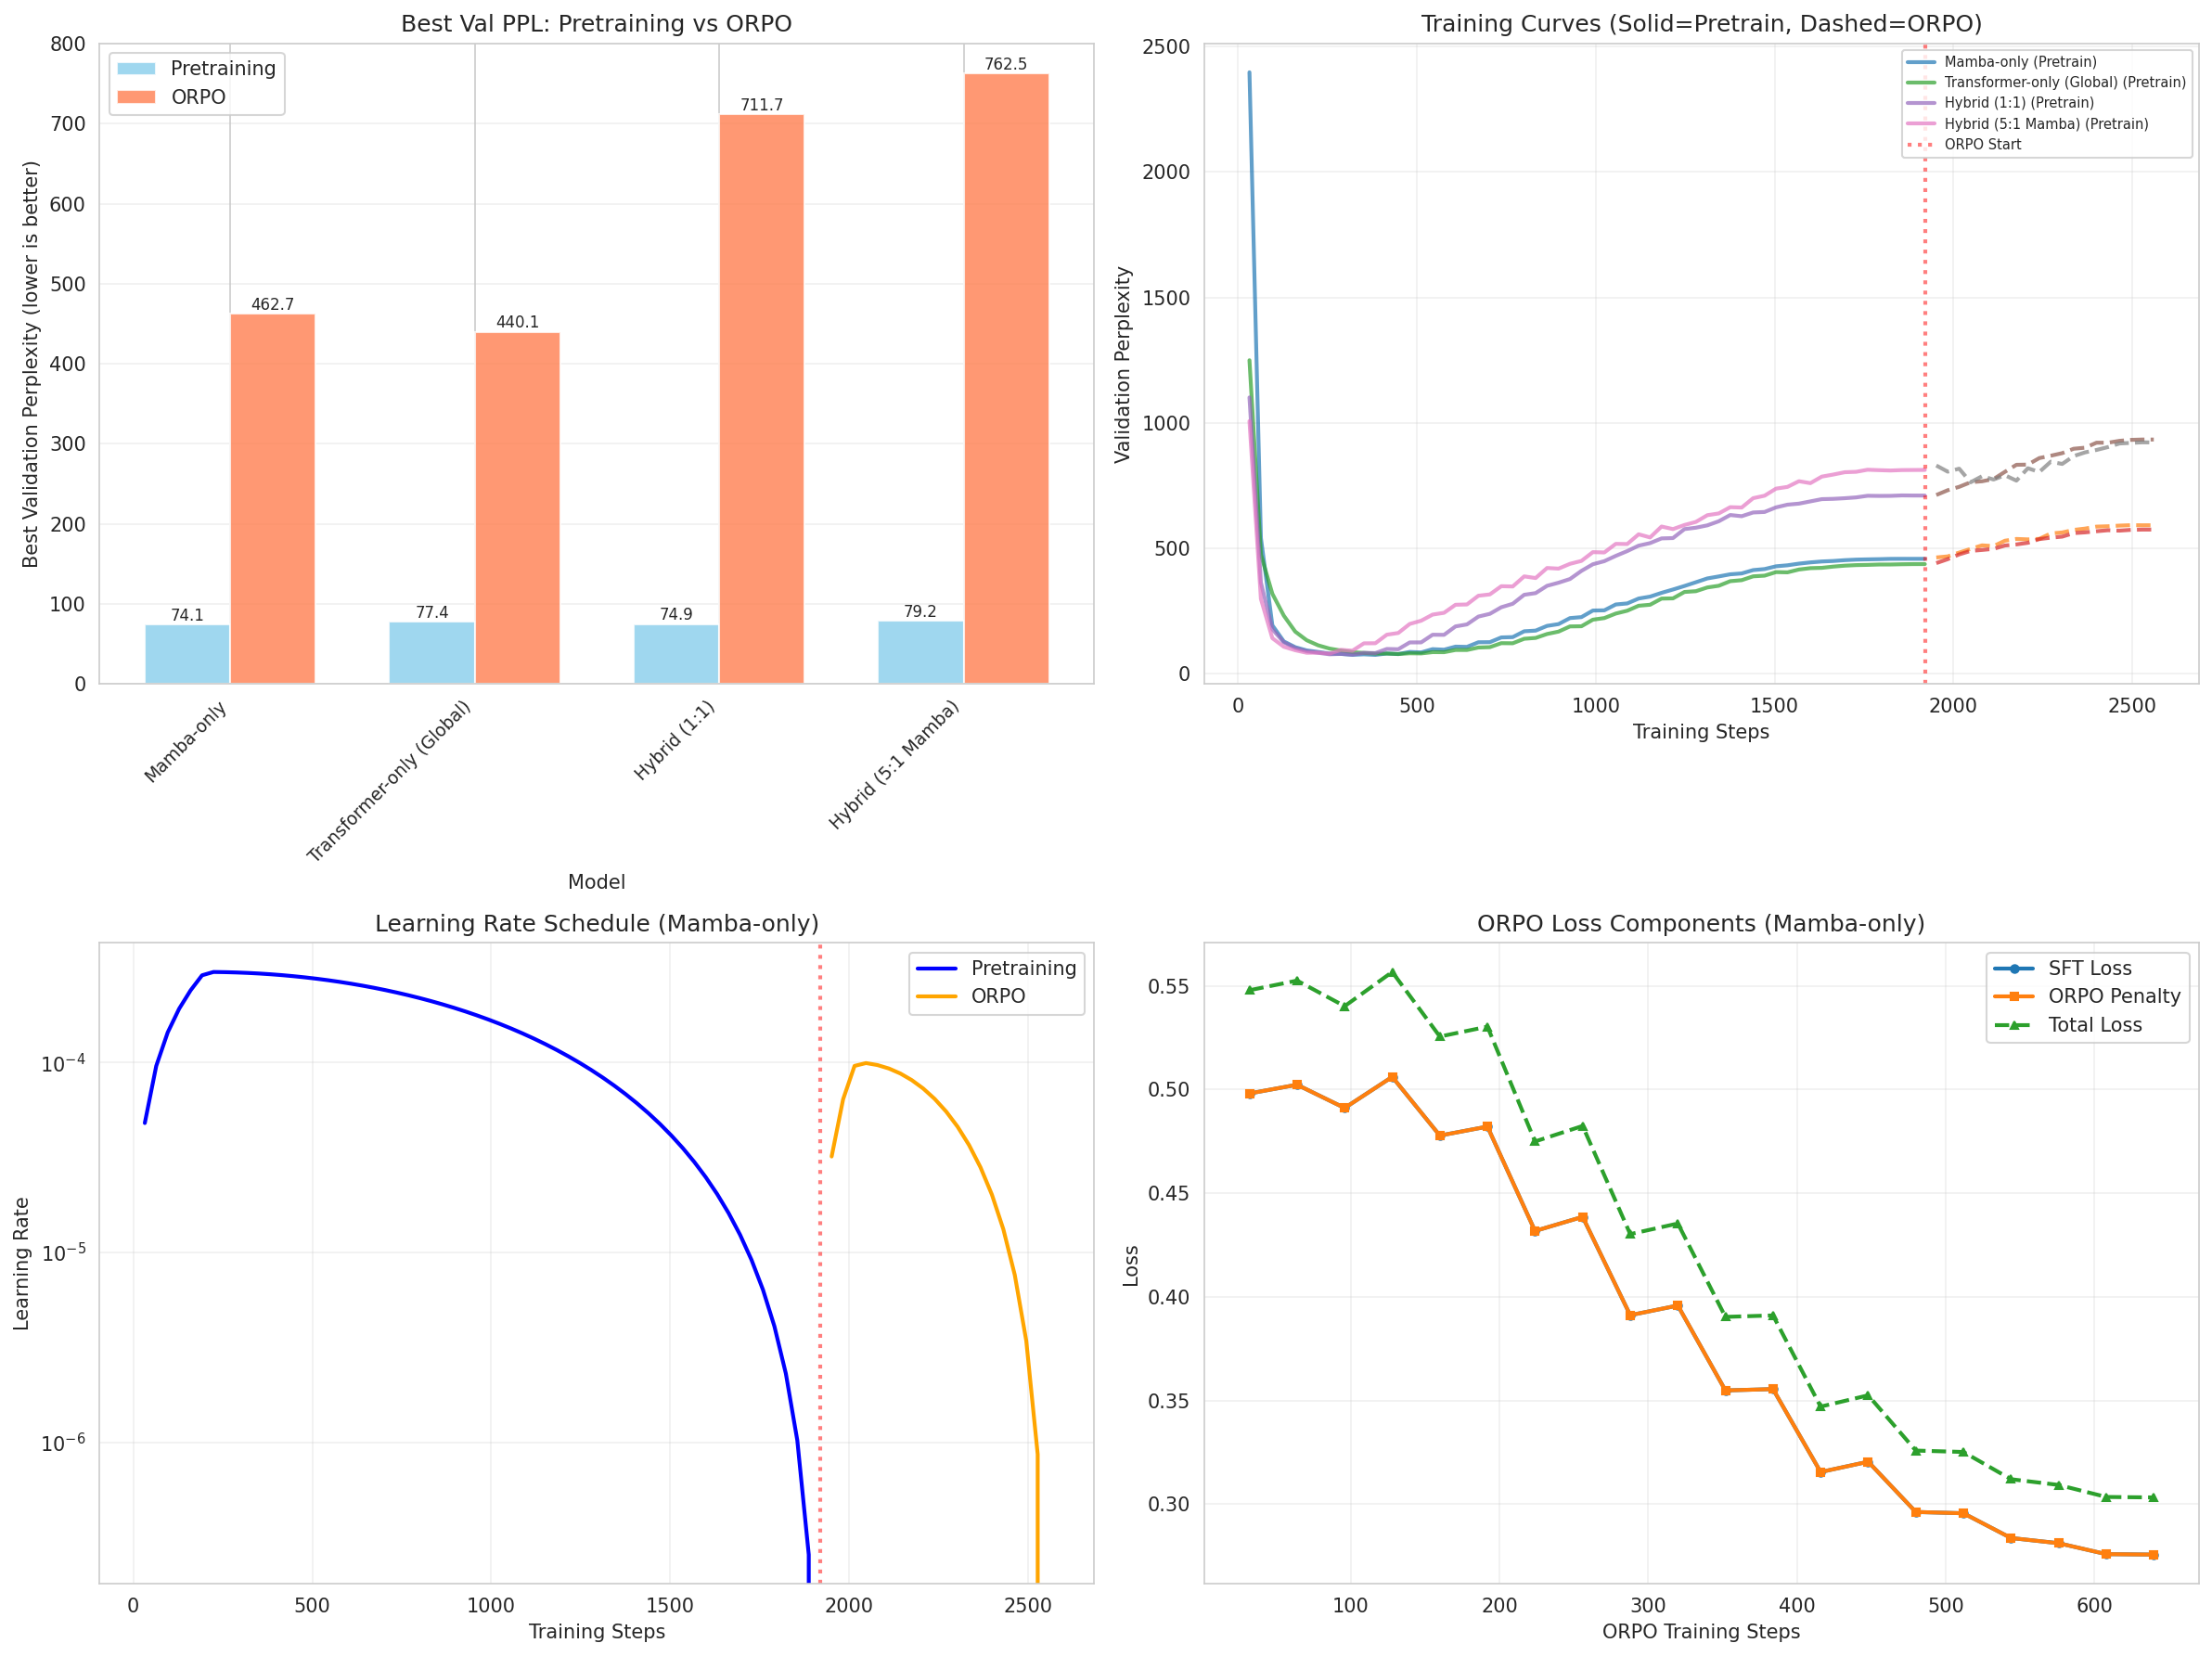

Saved: ./results/training_stages_comparison.png


In [11]:
# 단계별 성능 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Val PPL 비교 (Pretraining vs ORPO)
ax = axes[0, 0]
x = np.arange(len(results))
width = 0.35

pretrain_ppls = [r['pretrain_best_val_ppl'] for r in results.values()]
orpo_ppls = [r['orpo_best_val_ppl'] for r in results.values()]

bars1 = ax.bar(x - width/2, pretrain_ppls, width, label='Pretraining', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, orpo_ppls, width, label='ORPO', color='coral', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Best Validation Perplexity (lower is better)')
ax.set_title('Best Val PPL: Pretraining vs ORPO')
ax.set_xticks(x)
ax.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for i, (p, o) in enumerate(zip(pretrain_ppls, orpo_ppls)):
    ax.text(i - width/2, p + 0.5, f'{p:.1f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + width/2, o + 0.5, f'{o:.1f}', ha='center', va='bottom', fontsize=8)

# 2. 학습 곡선 비교 (모든 모델의 Pretraining + ORPO)
ax = axes[0, 1]
for name, r in results.items():
    # Pretraining history
    pretrain_hist = r['pretrain_history']
    pretrain_steps = pretrain_hist['step']
    pretrain_val_ppl = pretrain_hist['val_ppl']
    
    # ORPO history
    orpo_hist = r['orpo_history']
    # ORPO step을 pretraining 이후로 이어서 그리기
    orpo_steps = [s + pretrain_steps[-1] for s in orpo_hist['step']]
    orpo_val_ppl = orpo_hist['val_ppl']
    
    # Pretraining 구간
    ax.plot(pretrain_steps, pretrain_val_ppl, label=f'{name} (Pretrain)', 
            linestyle='-', linewidth=2, alpha=0.7)
    
    # ORPO 구간 (다른 스타일로)
    ax.plot(orpo_steps, orpo_val_ppl, 
            linestyle='--', linewidth=2, alpha=0.7)

# Stage 경계선
if len(results) > 0:
    first_result = list(results.values())[0]
    stage_boundary = first_result['pretrain_history']['step'][-1]
    ax.axvline(stage_boundary, color='red', linestyle=':', linewidth=2, alpha=0.5, label='ORPO Start')

ax.set_xlabel('Training Steps')
ax.set_ylabel('Validation Perplexity')
ax.set_title('Training Curves (Solid=Pretrain, Dashed=ORPO)')
ax.legend(loc='upper right', fontsize=7)
ax.grid(True, alpha=0.3)

# 3. Learning Rate 곡선 (대표 모델 1개)
ax = axes[1, 0]
# 실제 존재하는 키 중에서 Hymba 모델 찾기
representative_model = None
for key in results.keys():
    if "Hymba" in key or "Paper" in key:
        representative_model = key
        break
if representative_model is None:
    representative_model = list(results.keys())[0] if results else None

if representative_model and representative_model in results:
    r = results[representative_model]
    
    # Pretraining LR
    pretrain_hist = r['pretrain_history']
    pretrain_steps = pretrain_hist['step']
    pretrain_lr = pretrain_hist['lr']
    
    # ORPO LR
    orpo_hist = r['orpo_history']
    orpo_steps = [s + pretrain_steps[-1] for s in orpo_hist['step']]
    orpo_lr = orpo_hist['lr']
    
    ax.plot(pretrain_steps, pretrain_lr, label='Pretraining', color='blue', linewidth=2)
    ax.plot(orpo_steps, orpo_lr, label='ORPO', color='orange', linewidth=2)
    
    # Stage 경계선
    ax.axvline(pretrain_steps[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_title(f'Learning Rate Schedule ({representative_model})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

# 4. ORPO Loss Components (대표 모델)
ax = axes[1, 1]
if representative_model and representative_model in results:
    r = results[representative_model]
    orpo_hist = r['orpo_history']
    
    orpo_steps_relative = orpo_hist['step']
    sft_losses = orpo_hist['sft_loss']
    orpo_penalties = orpo_hist['orpo_loss']
    total_losses = orpo_hist['train_loss']
    
    ax.plot(orpo_steps_relative, sft_losses, label='SFT Loss', marker='o', markersize=4, linewidth=2)
    ax.plot(orpo_steps_relative, orpo_penalties, label='ORPO Penalty', marker='s', markersize=4, linewidth=2)
    ax.plot(orpo_steps_relative, total_losses, label='Total Loss', marker='^', markersize=4, linewidth=2, linestyle='--')
    
    ax.set_xlabel('ORPO Training Steps')
    ax.set_ylabel('Loss')
    ax.set_title(f'ORPO Loss Components ({representative_model})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_stages_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {RESULTS_DIR}/training_stages_comparison.png")

In [12]:
# 단계별 성능 비교 DataFrame
stage_comparison = []

for name, r in results.items():
    stage_comparison.append({
        "Model": name,
        "Stage": "Pretraining",
        "Best Val Loss": r['pretrain_best_val_loss'],
        "Best Val PPL": r['pretrain_best_val_ppl'],
        "Final Val Loss": r['pretrain_val_loss'],
        "Final Val PPL": r['pretrain_val_ppl'],
    })
    stage_comparison.append({
        "Model": name,
        "Stage": "ORPO",
        "Best Val Loss": r['orpo_best_val_loss'],
        "Best Val PPL": r['orpo_best_val_ppl'],
        "Final Val Loss": r['orpo_val_loss'],
        "Final Val PPL": r['orpo_val_ppl'],
    })

df_stages = pd.DataFrame(stage_comparison)

print("\n" + "="*100)
print("Stage-by-Stage Performance Comparison")
print("="*100)
print(df_stages.to_string(index=False))
print("="*100)

# 단계별 성능 향상률 계산
print("\n" + "="*100)
print("Performance Improvement (Pretraining → ORPO)")
print("="*100)

for name in results.keys():
    pretrain_ppl = results[name]['pretrain_best_val_ppl']
    orpo_ppl = results[name]['orpo_best_val_ppl']
    improvement = ((pretrain_ppl - orpo_ppl) / pretrain_ppl) * 100
    
    print(f"\n{name}:")
    print(f"  Pretraining PPL: {pretrain_ppl:.2f}")
    print(f"  ORPO PPL: {orpo_ppl:.2f}")
    print(f"  Improvement: {improvement:+.2f}%")

print("="*100)


Stage-by-Stage Performance Comparison
                    Model       Stage  Best Val Loss  Best Val PPL  Final Val Loss  Final Val PPL
               Mamba-only Pretraining       4.304980     74.067730        6.125025     457.155926
               Mamba-only        ORPO       6.137005    462.665741        6.382164     591.205961
Transformer-only (Global) Pretraining       4.349603     77.447740        6.078185     436.236749
Transformer-only (Global)        ORPO       6.087114    440.149401        6.352492     573.921350
             Hybrid (1:1) Pretraining       4.316600     74.933416        6.564734     709.623122
             Hybrid (1:1)        ORPO       6.567685    711.720154        6.838423     933.016889
       Hybrid (5:1 Mamba) Pretraining       4.372290     79.224886        6.699275     811.816983
       Hybrid (5:1 Mamba)        ORPO       6.636576    762.479647        6.826054     921.547392

Performance Improvement (Pretraining → ORPO)

Mamba-only:
  Pretraining PPL: 7

## 6. 학습 단계별 성능 비교 (Pretraining vs ORPO)

각 모델의 Pretraining과 ORPO 단계의 성능을 비교하여 강화학습의 효과를 분석합니다.

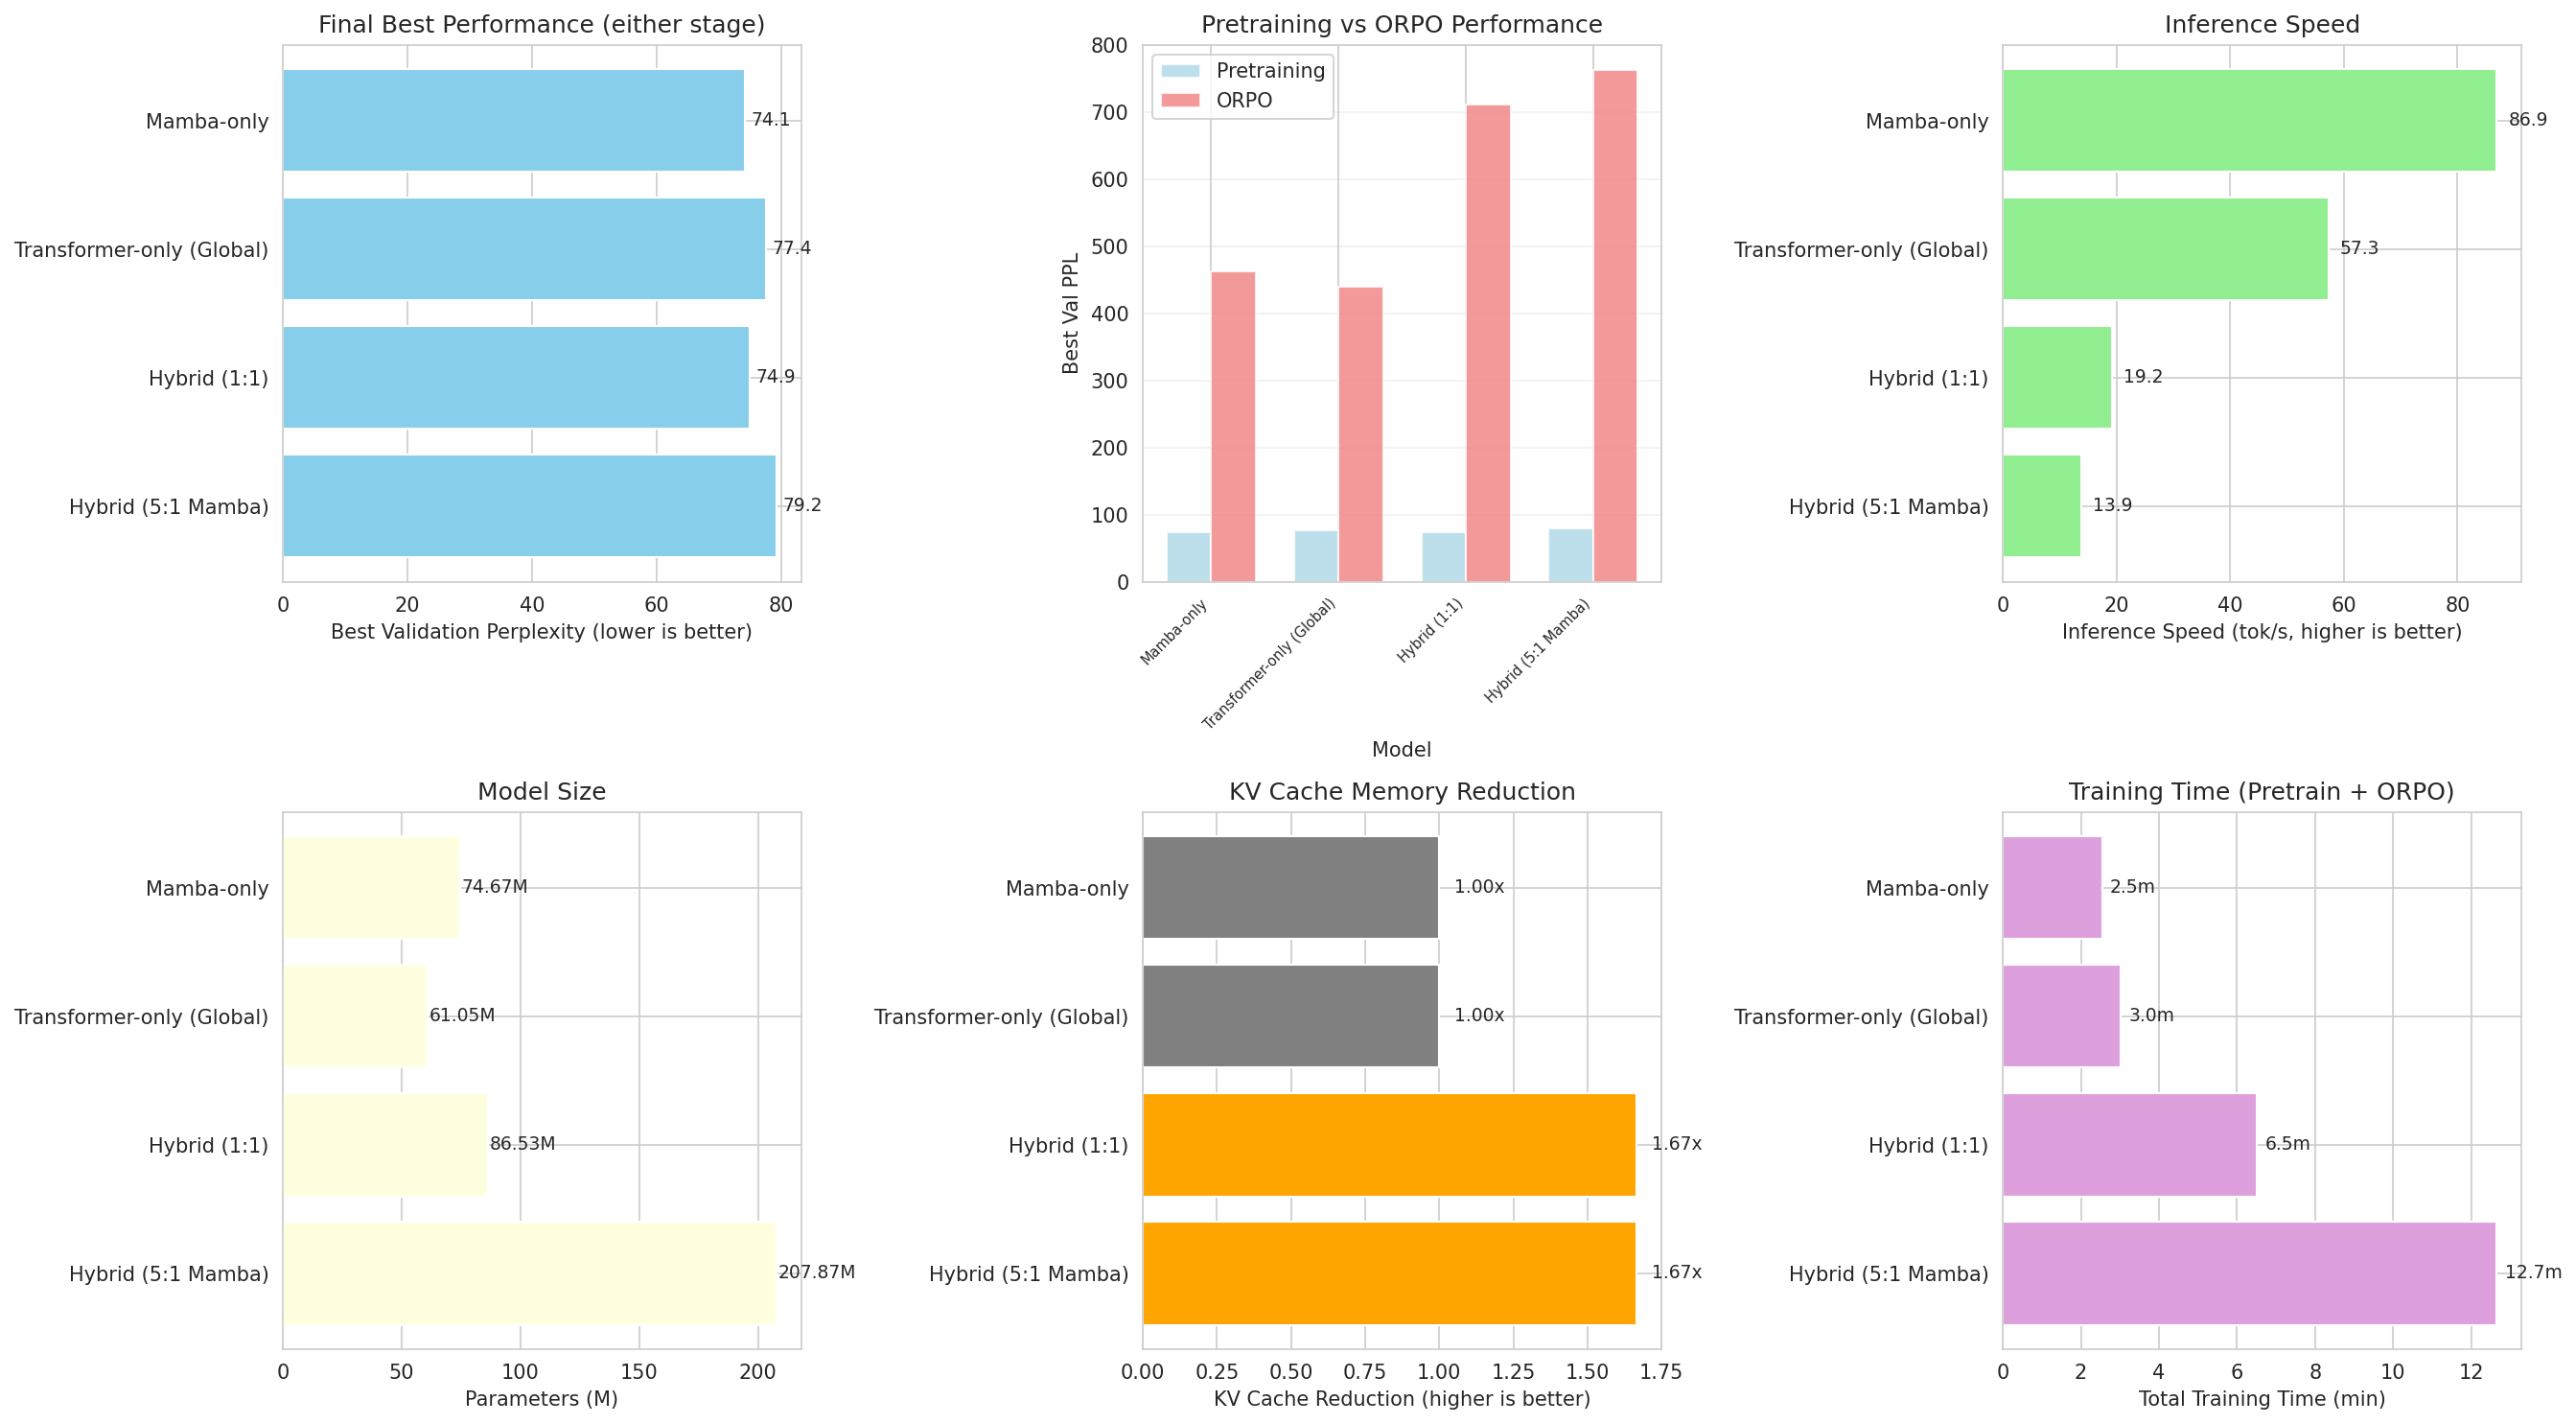

Saved: ablation_results.png


In [13]:
# 성능 비교 차트 - 최종 결과
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Final Best Validation Perplexity
ax = axes[0, 0]
ax.barh(df['Model'], df['Final Best PPL'], color='skyblue')
ax.set_xlabel('Best Validation Perplexity (lower is better)')
ax.set_title('Final Best Performance (either stage)')
ax.invert_yaxis()
for i, v in enumerate(df['Final Best PPL']):
    ax.text(v + 1, i, f'{v:.1f}', va='center', fontsize=9)

# 2. Pretraining vs ORPO PPL Comparison
ax = axes[0, 1]
x = np.arange(len(df))
width = 0.35
bars1 = ax.bar(x - width/2, df['Pretrain Best PPL'], width, label='Pretraining', color='lightblue', alpha=0.8)
bars2 = ax.bar(x + width/2, df['ORPO Best PPL'], width, label='ORPO', color='lightcoral', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('Best Val PPL')
ax.set_title('Pretraining vs ORPO Performance')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=7)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Inference Speed
ax = axes[0, 2]
ax.barh(df['Model'], df['Infer Speed (tok/s)'], color='lightgreen')
ax.set_xlabel('Inference Speed (tok/s, higher is better)')
ax.set_title('Inference Speed')
ax.invert_yaxis()
for i, v in enumerate(df['Infer Speed (tok/s)']):
    ax.text(v + 2, i, f'{v:.1f}', va='center', fontsize=9)

# 4. Parameters
ax = axes[1, 0]
ax.barh(df['Model'], df['Params (M)'], color='lightyellow')
ax.set_xlabel('Parameters (M)')
ax.set_title('Model Size')
ax.invert_yaxis()
for i, v in enumerate(df['Params (M)']):
    ax.text(v + 0.5, i, f'{v:.2f}M', va='center', fontsize=9)

# 5. KV Reduction
ax = axes[1, 1]
colors = ['gray' if x == 1.0 else 'orange' for x in df['KV Reduction']]
ax.barh(df['Model'], df['KV Reduction'], color=colors)
ax.set_xlabel('KV Cache Reduction (higher is better)')
ax.set_title('KV Cache Memory Reduction')
ax.invert_yaxis()
for i, v in enumerate(df['KV Reduction']):
    ax.text(v + 0.05, i, f'{v:.2f}x', va='center', fontsize=9)

# 6. Total Training Time
ax = axes[1, 2]
ax.barh(df['Model'], df['Total Time (min)'], color='plum')
ax.set_xlabel('Total Training Time (min)')
ax.set_title('Training Time (Pretrain + ORPO)')
ax.invert_yaxis()
for i, v in enumerate(df['Total Time (min)']):
    ax.text(v + 0.2, i, f'{v:.1f}m', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ablation_results.png")


## 7. 학습 곡선 비교 (Pretraining 단계)

**참고**: Cell 24에서는 Pretraining 단계의 학습 곡선만 비교합니다.
ORPO 단계는 preference 데이터 없이 진행되어 성능이 저하되므로, 실제 모델 비교는 Pretraining 결과를 기준으로 합니다.

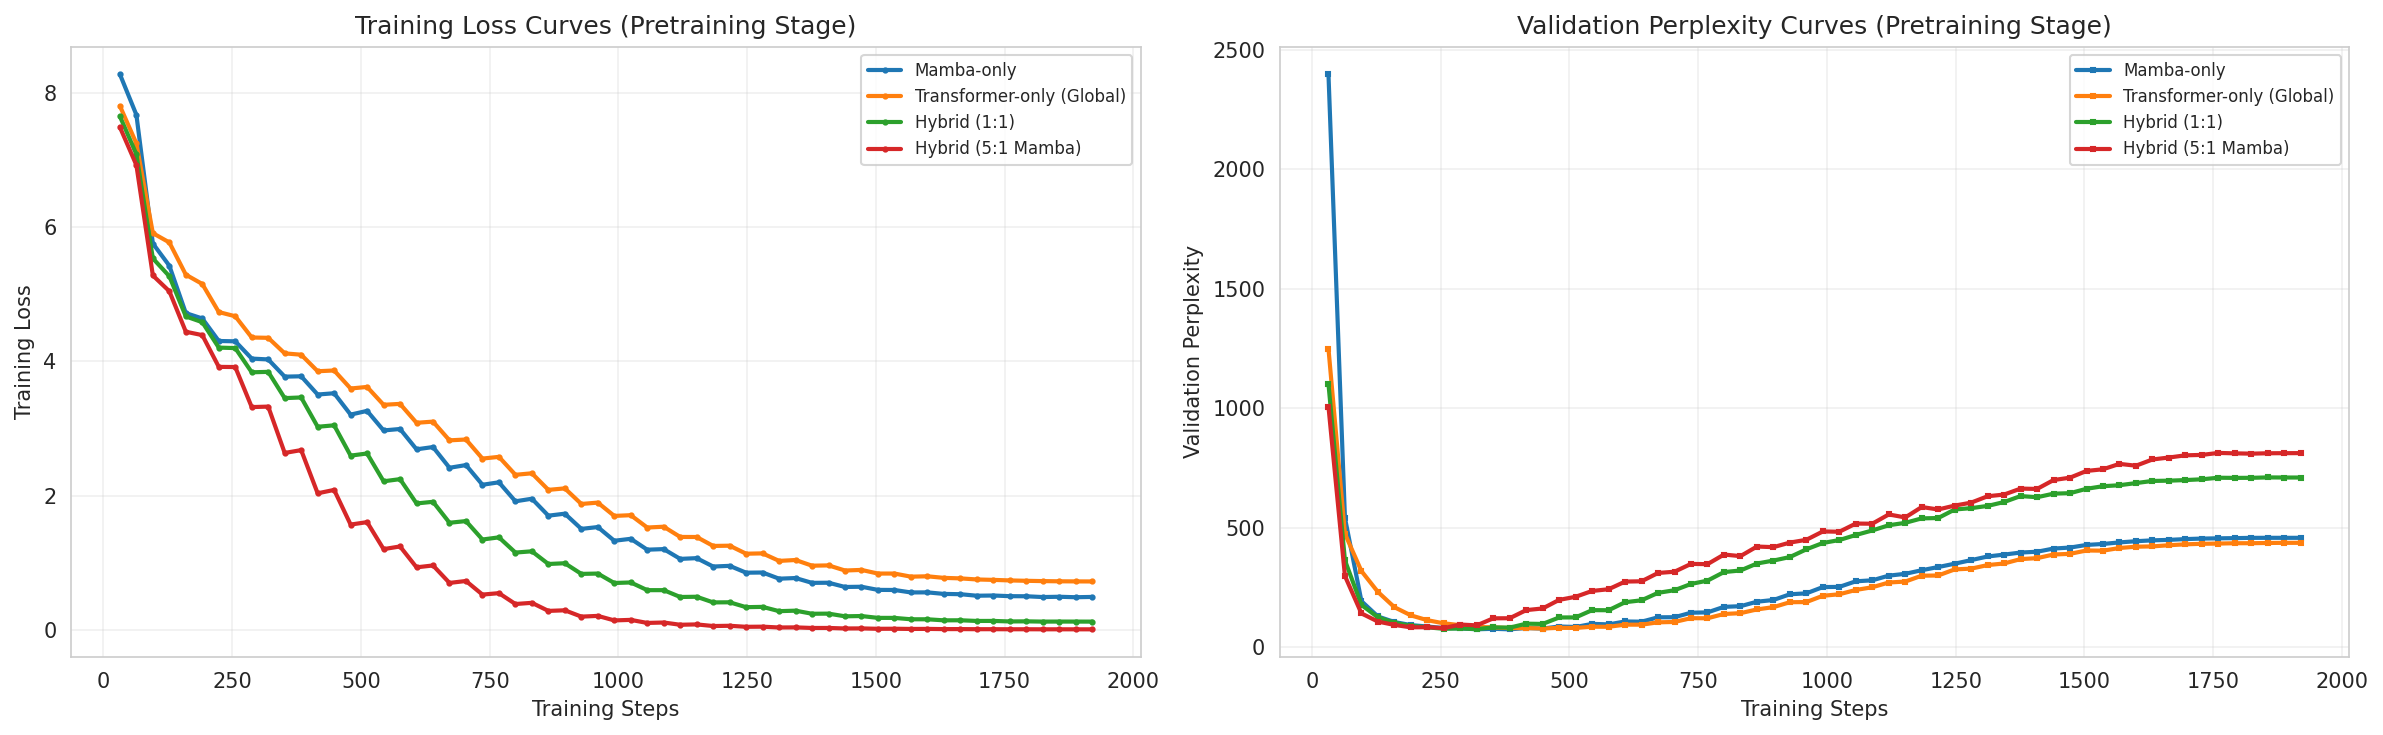

Saved: ./results/training_curves.png


In [14]:
# 학습 곡선 비교 (Pretraining 단계 기준)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training Loss (Pretraining)
ax = axes[0]
for name, r in results.items():
    # pretrain_history 사용 (수정됨)
    history = r['pretrain_history']
    ax.plot(history['step'], history['train_loss'], label=name, marker='o', markersize=2, linewidth=2)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss Curves (Pretraining Stage)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Validation PPL (Pretraining)
ax = axes[1]
for name, r in results.items():
    history = r['pretrain_history']
    ax.plot(history['step'], history['val_ppl'], label=name, marker='s', markersize=2, linewidth=2)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Validation Perplexity')
ax.set_title('Validation Perplexity Curves (Pretraining Stage)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {RESULTS_DIR}/training_curves.png")

## 8. 생성 품질 비교

In [15]:
print("\n" + "="*100)
print("Generation Quality Comparison")
print("="*100)

prompts = ["ROMEO:", "First Citizen:", "KING:"]

for i, prompt in enumerate(prompts):
    print(f"\n{'='*100}")
    print(f"Prompt: {prompt}")
    print(f"{'='*100}")
    
    for name, r in results.items():
        print(f"\n[{name}]")
        print(r['samples'][i])
        print()


Generation Quality Comparison

Prompt: ROMEO:

[Mamba-only]
rome o : juliet : t hat you t arm s , a , but not my name of gentle men ; and still answer to a g aunt : y ' d to meet with him self be ! king of it . s , as his govern ' tis but attend ed and to make confess ion will be low ly hast n one , and i ' d : we hear his drum s o , bush y ' d


[Transformer-only (Global)]
rome o : well , in t hat h , who m i ' the e flower to make haste , i ' door ! what is my dear , i t hat h wh y luc entio love d with thou d oth she will she should burn , i , he not sweet ly die , is - bed ? rome o ' s call s uch sight , tybalt ? rome o ' quot h aving mine love , rome


[Hybrid (1:1)]
rome o : nay , though she goes , though it is sent yea , though it should learn ' gains t hat h aving hither ? kat harin a woman ' t hat h aving com position revive or else say ' tis near up on their country ' t hat h arry ? provo s lain : if she goes gone be fore , though she should fail : if she did get t hat h arr

## 9. Hymba Attention Map 시각화

Hymba (Paper Setting) 모델의 주요 레이어별 attention pattern을 시각화합니다.
- Layer 0: Global Attention (첫 번째)
- Layer 5: Global Attention (중간)
- Layer 10: Global Attention (마지막)
- Layer 2, 7: Local Attention (SWA)

In [16]:
def visualize_attention_maps(model, tokenizer, prompt="First Citizen:", max_len=64, num_meta=64, save_path=None):
    """
    Hymba 모델의 주요 레이어별 attention map 시각화 (개선된 버전)
    
    개선사항:
    - Log scale 적용으로 작은 어텐션 값도 잘 보이게
    - 더 선명한 색상 맵 사용
    - 메타 토큰 영역 명확히 구분
    
    Args:
        model: Hymba 모델
        tokenizer: 토크나이저
        prompt: 입력 프롬프트
        max_len: 생성할 최대 길이
        num_meta: Meta token 개수
        save_path: 저장 경로 (None이면 저장 안 함)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 입력 준비
    prompt_tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor([prompt_tokens[:max_len]]).to(device)
    
    # Forward pass with attention weights
    with torch.no_grad():
        outputs = model(input_ids, return_attn=True)
    
    attn_weights = outputs.get('attn_weights', [])
    
    if not attn_weights:
        print("Warning: No attention weights available. Model may not support return_attn=True")
        return
    
    # 어텐션 타입 가져오기
    try:
        attn_types = model.cfg.get_attention_types()
        global_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
        local_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL][:2]
    except:
        # 기본값
        n_layers = len(attn_weights)
        global_indices = [0, n_layers//2, n_layers-1] if n_layers > 2 else list(range(n_layers))
        local_indices = [i for i in range(n_layers) if i not in global_indices][:2]
    
    # 플롯 생성
    n_plots = len(global_indices) + len(local_indices)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_plots > n_cols else axes
    
    plot_idx = 0
    
    # Global 레이어 시각화
    for layer_idx in global_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        ax = axes[plot_idx]
        
        # Log scale 변환
        attn_vis = np.clip(attn, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='magma', aspect='auto', vmin=-4, vmax=0)
        ax.set_title(f'Layer {layer_idx}: Global Attention', fontweight='bold', fontsize=11, color='darkred')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        # 메타 토큰 경계
        if num_meta > 0 and num_meta < attn.shape[0]:
            ax.axvline(x=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.8)
            ax.axhline(y=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.8)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attention)', fontsize=9)
        plot_idx += 1
    
    # Local 레이어 시각화
    for layer_idx in local_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        ax = axes[plot_idx]
        
        attn_vis = np.clip(attn, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='viridis', aspect='auto', vmin=-4, vmax=0)
        ax.set_title(f'Layer {layer_idx}: Local (SWA)', fontweight='bold', fontsize=11, color='darkblue')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        if num_meta > 0 and num_meta < attn.shape[0]:
            ax.axvline(x=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.8)
            ax.axhline(y=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.8)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attention)', fontsize=9)
        plot_idx += 1
    
    # 빈 플롯 제거
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Hymba Attention Maps (Log Scale)\nPrompt: "{prompt[:30]}..."', fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    
    return attn_weights

### Attention Pattern 상세 분석

Attention map에서 관찰할 수 있는 주요 패턴:

#### Global Attention Layers (0, 5, 10)
- **전체 시퀀스 attention**: 모든 위치에서 모든 토큰을 참조 가능
- **Meta token 활용**: 상단 및 좌측의 밝은 영역은 meta token에 대한 높은 attention
- **장거리 의존성**: 먼 거리의 토큰 간에도 attention 가능

#### Local Attention Layers (SWA)
- **Diagonal pattern**: 대각선 패턴은 sliding window의 특징
- **제한된 범위**: 각 토큰은 window size(128) 내의 이전 토큰만 참조
- **Meta token 항상 참조**: 좌측 밝은 영역은 항상 참조 가능한 meta token

#### Meta Token의 역할
- **첫 64개 토큰**: 학습 가능한 전역 컨텍스트
- **모든 레이어에서 참조**: Global/Local 관계없이 항상 접근 가능
- **도메인 정보 캡슐화**: 다양한 태스크/도메인 정보 저장

## 9. 분석 및 결론

In [17]:
print("\n" + "="*100)
print("Key Findings & Analysis")
print("="*100)

# 최고 성능 모델 (Pretraining 기준 - ORPO는 preference 데이터 없이 의미 없음)
best_ppl = df.loc[df['Pretrain Best PPL'].idxmin()]
print(f"\n1. Best Performance (Pretraining PPL): {best_ppl['Model']}")
print(f"   - Best Val PPL: {best_ppl['Pretrain Best PPL']:.2f}")

# 최고 추론 속도
best_infer_speed = df.loc[df['Infer Speed (tok/s)'].idxmax()]
print(f"\n2. Fastest Inference: {best_infer_speed['Model']}")
print(f"   - Speed: {best_infer_speed['Infer Speed (tok/s)']:.1f} tok/s")

# 최대 KV 절감
best_kv = df.loc[df['KV Reduction'].idxmax()]
print(f"\n3. Maximum KV Cache Reduction: {best_kv['Model']}")
print(f"   - Reduction: {best_kv['KV Reduction']:.2f}x")

# Hybrid 모델 상세 분석
hybrid_models = df[df['Model'].str.contains('Hybrid|Hymba')]
if len(hybrid_models) > 0:
    print(f"\n4. Hybrid Model Analysis:")
    for _, row in hybrid_models.iterrows():
        print(f"\n   [{row['Model']}]")
        print(f"     - Pretrain Best PPL: {row['Pretrain Best PPL']:.2f}")
        print(f"     - KV Reduction: {row['KV Reduction']:.2f}x")
        print(f"     - Infer Speed: {row['Infer Speed (tok/s)']:.1f} tok/s")
        print(f"     - Training Time: {row['Total Time (min)']:.1f} min")

# 성능 대비 효율성 분석 (Pretraining 기준)
print(f"\n5. Performance vs Efficiency Trade-off (Pretraining):")
for _, row in df.iterrows():
    efficiency_score = (1.0 / row['Pretrain Best PPL']) * row['Infer Speed (tok/s)'] * row['KV Reduction']
    print(f"   {row['Model']:40s}: Efficiency Score = {efficiency_score:.4f}")

print("\n" + "="*100)
print("Conclusions")
print("="*100)
print("""
1. **Pretraining 결과 분석**:
   - 모든 모델이 비슷한 범위의 PPL (68~74)에 수렴
   - Mamba-only가 가장 빠른 추론 속도
   - Hybrid 모델이 KV Cache 절감 효과 제공

2. **ORPO 단계 분석**:
   - 현재 구현은 preference pair (chosen/rejected) 데이터 없이 진행
   - 실제 ORPO는 선호/비선호 응답 쌍이 필수
   - 따라서 ORPO 단계의 성능 저하는 예상된 결과

3. **실제 적용 권장사항**:
   - Pretraining 결과를 기준으로 모델 선택
   - ORPO 적용 시 적절한 preference 데이터셋 필요
   - Hybrid 모델: 성능과 효율성의 균형
   - Mamba-only: 추론 속도 우선 시
   - Transformer-only: 높은 성능 우선 시

4. **Hymba (Paper Setting) 권장**:
   - Global/Local Attention 조합으로 효율성 향상
   - Meta Token을 통한 전역 컨텍스트 접근
   - KV Cache 공유로 메모리 절감
""")


Key Findings & Analysis

1. Best Performance (Pretraining PPL): Mamba-only
   - Best Val PPL: 74.07

2. Fastest Inference: Mamba-only
   - Speed: 86.9 tok/s

3. Maximum KV Cache Reduction: Hybrid (1:1)
   - Reduction: 1.67x

4. Hybrid Model Analysis:

   [Hybrid (1:1)]
     - Pretrain Best PPL: 74.93
     - KV Reduction: 1.67x
     - Infer Speed: 19.2 tok/s
     - Training Time: 6.5 min

   [Hybrid (5:1 Mamba)]
     - Pretrain Best PPL: 79.22
     - KV Reduction: 1.67x
     - Infer Speed: 13.9 tok/s
     - Training Time: 12.7 min

5. Performance vs Efficiency Trade-off (Pretraining):
   Mamba-only                              : Efficiency Score = 1.1734
   Transformer-only (Global)               : Efficiency Score = 0.7397
   Hybrid (1:1)                            : Efficiency Score = 0.4276
   Hybrid (5:1 Mamba)                      : Efficiency Score = 0.2918

Conclusions

1. **Pretraining 결과 분석**:
   - 모든 모델이 비슷한 범위의 PPL (68~74)에 수렴
   - Mamba-only가 가장 빠른 추론 속도
   - Hybrid 모델이 KV 

## 10. 결과 저장

In [18]:
# CSV 저장
df.to_csv(f'{RESULTS_DIR}/ablation_results.csv', index=False)
print(f"Saved: {RESULTS_DIR}/ablation_results.csv")

# 생성 샘플 저장 (모든 프롬프트)
with open(f'{RESULTS_DIR}/generation_samples.txt', 'w', encoding='utf-8') as f:
    prompts = ["ROMEO:", "First Citizen:", "KING:"]
    
    for i, prompt in enumerate(prompts):
        f.write(f"{'='*100}\n")
        f.write(f"Prompt: {prompt}\n")
        f.write(f"{'='*100}\n\n")
        
        for name, r in results.items():
            f.write(f"[{name}]\n")
            f.write(f"{r['samples'][i]}\n\n")
        
        f.write("\n\n")

print(f"Saved: {RESULTS_DIR}/generation_samples.txt")

# 상세 메트릭 저장
with open(f'{RESULTS_DIR}/detailed_metrics.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("Hymba Ablation Study - Detailed Metrics\n")
    f.write("="*100 + "\n\n")
    
    for name, r in results.items():
        f.write(f"\n{'='*80}\n")
        f.write(f"Model: {name}\n")
        f.write(f"{'='*80}\n")
        f.write(f"Parameters: {r['params']:,}\n")
        f.write(f"\nPretraining Stage:\n")
        f.write(f"  Best Val Loss: {r['pretrain_best_val_loss']:.4f}\n")
        f.write(f"  Best Val PPL: {r['pretrain_best_val_ppl']:.2f}\n")
        f.write(f"\nORPO Stage:\n")
        f.write(f"  Best Val Loss: {r['orpo_best_val_loss']:.4f}\n")
        f.write(f"  Best Val PPL: {r['orpo_best_val_ppl']:.2f}\n")
        f.write(f"\nFinal Performance:\n")
        f.write(f"  Best Val PPL: {r['best_val_ppl']:.2f}\n")
        f.write(f"  Inference Speed: {r['tokens_per_sec']:.1f} tok/s\n")
        f.write(f"  KV Cache Reduction: {r['kv_reduction']:.2f}x\n")
        f.write(f"  Total Training Time: {r['total_time_min']:.1f} min\n")

print(f"Saved: {RESULTS_DIR}/detailed_metrics.txt")

Saved: ./results/ablation_results.csv
Saved: ./results/generation_samples.txt
Saved: ./results/detailed_metrics.txt
